# ASTR 596: FDS Homework 6+7: Gaussian Processes (200 pts)

### This is a double HW set so you get extra time - until reading day (May 4th, 2023) at noon to do it. 
### After that, it's finals time. 


# P1. Gaussian Processes

### Last HW, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [20]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import scipy.stats as st
import sklearn
import sklearn.ensemble

In [21]:
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


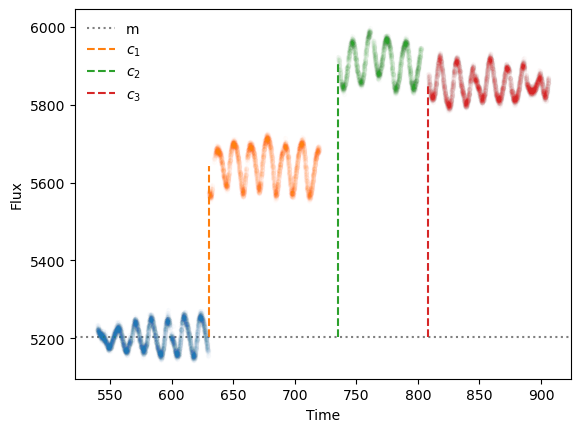

In [22]:
qs = sorted(np.unique(tab['quarter']))
plt.figure()
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = (tab['quarter'] == q)
    t = tab[ind]
    plt.errorbar(t['time'], t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=':')
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--')
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)
plt.show()

### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations. (20 pts)

In [23]:
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel

def get_kernel(A, gamma, P, lam):
    return A * ExpSine2Kernel(gamma=gamma, log_period=np.log(P)) * ExpSquaredKernel(metric=lam/2)

### Q2: To implement the full model, read how to use `george`'s modeling protocol: (20 pts)
https://george.readthedocs.io/en/latest/tutorials/model/

In [24]:
from george.modeling import Model

t1 = tab['time'][cycle_map[7]][0]
t2 = tab['time'][cycle_map[8]][0]
t3 = tab['time'][cycle_map[9]][0]

print(t1, t2, t3)

class MyModel(Model):
    parameter_names = ('m', 'c1', 'c2', 'c3')
    
    def get_value(self, t):
        return self.m + np.where(t < t1, 0,
                                 np.where(t < t2, self.c1,
                                          np.where(t < t3, self.c2, self.c3)))

630.1958363732629 735.40366757843 808.5360293126505


In [25]:
gp = george.GP(mean=MyModel(m=means[0], c1=means[1]-means[0], c2=means[2]-means[0], c3=means[3]-means[0]),
               kernel=get_kernel(20, 5, 20, 20), fit_mean=True)
print(gp.get_parameter_vector())

[5.20379938e+03 4.40027437e+02 7.02210040e+02 6.48388347e+02
 2.99573227e+00 5.00000000e+00 2.99573227e+00 2.30258509e+00]


### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots) (20 pts)

In [26]:
def gaussian(x, mu, sigma):
    return np.exp(-((x - mu) / sigma)**2 / 2) / np.sqrt(2 * np.pi) / sigma

def lnprior(theta, y):
    m, c1, c2, c3, logA, gamma, logP, loghalflam = theta
    
    result = 0
    result += np.log(gaussian(m, means[0], 30))
    for (i, param) in enumerate([c1, c2, c3]):
        result += np.log(gaussian(param, means[i] - means[0], 30))
    
    return result

def lnprob(theta, y):
    gp.set_parameter_vector(theta)
    return gp.log_likelihood(y, quiet=True) + lnprior(theta, y)

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps) (20 pts)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help 

In [27]:
from scipy.optimize import minimize

# Use scipy to get a better estimate of where the parameters should be
def nll(theta, y):
    gp.set_parameter_vector(theta)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

gp.compute(tab['flux'][::10], tab['error'][::10])

p0 = gp.get_parameter_vector()
print(gp.log_likelihood(tab['flux'][::10]))
results = minimize(nll, p0, args=(tab['flux'][::10],))
gp.set_parameter_vector(results.x)

print(gp.get_parameter_vector())

-305595.3273620718
[ 5.20374306e+03  4.40027437e+02  7.02210040e+02  6.48332028e+02
  9.37689832e+00  2.14607678e-01 -5.31495921e+00  1.12884084e+01]


In [28]:
import emcee
import numpy as np

rng = np.random.default_rng(0)

n_dim     = len(gp)
n_walkers = 2 * n_dim
n_burnin  = 300
n_steps   = 500

p0 = gp.get_parameter_vector() + 1e-4 * rng.standard_normal((n_walkers, n_dim))
print(gp.get_parameter_vector())

[ 5.20374306e+03  4.40027437e+02  7.02210040e+02  6.48332028e+02
  9.37689832e+00  2.14607678e-01 -5.31495921e+00  1.12884084e+01]


In [29]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, lnprob, args=(tab['flux'][::10],))
sampler.run_mcmc(p0, n_burnin, progress=True)
sampler.reset()
sampler.run_mcmc(None, n_steps, progress=True)
chain = sampler.get_chain(flat=True)
np.save('chain.npy', chain)

100%|██████████| 500/500 [13:34<00:00,  1.63s/it]


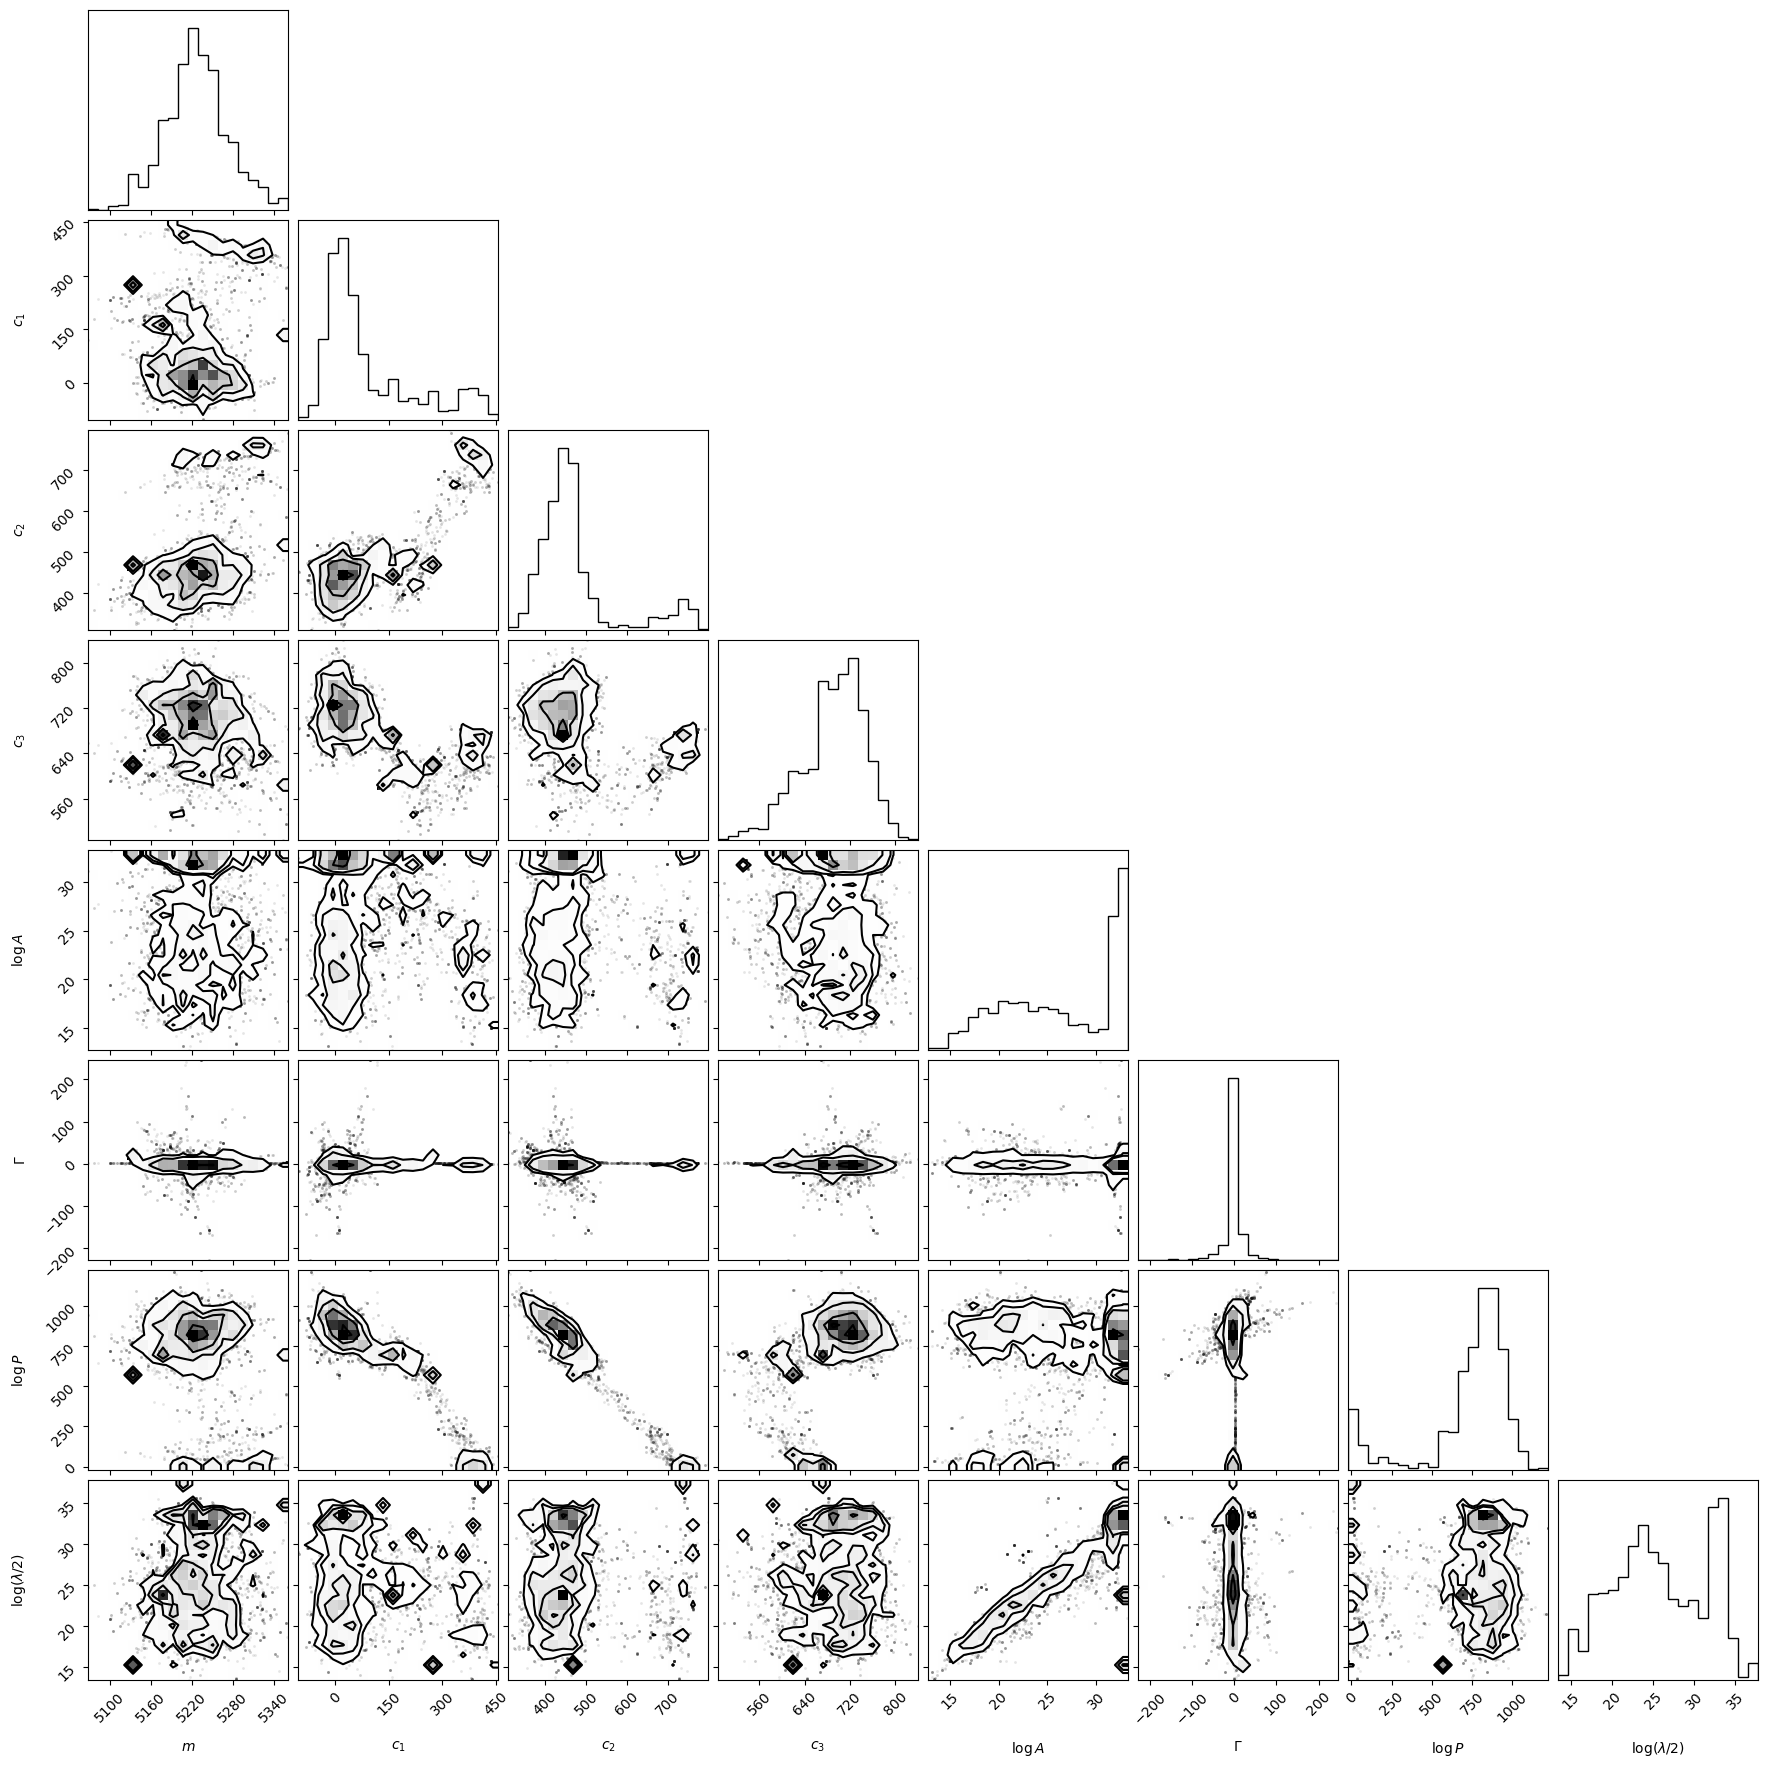

In [30]:
import corner

chain = np.load('chain.npy')
labels = [r'$m$', r'$c_{1}$', r'$c_{2}$', r'$c_{3}$', r'$\log A$', r'$\Gamma$', r'$\log P$', r'$\log(\lambda/2)$']
corner.corner(chain, labels=labels)
plt.show()

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black.  (20 pts)

# P2. Random Forests

For this work, we'll use the datasets produced by [Dey et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.515.5285D/abstract), who trained a deep capsule network on postage stamps of SDSS galaxies to predict photometric redshifts. 

We're not going to use a deep capsule network on postage stamps, but we can use tabular data. This won't be as performant, but it's still instructive to see how well we can do with a simple random forest. Dey et al. have done an excellent job making their data available - http://d-scholarship.pitt.edu/42023/ (all of it)

You will need the [training set](http://d-scholarship.pitt.edu/42023/9/cat_train.csv) and the [test set](http://d-scholarship.pitt.edu/42023/8/cat_test.csv).

I suggest reading through Sec. 2 of the paper to get some sense of what the data is. Importantly, the data includes columns for photometric redshift already. You can't use these to train your random forest (duh.). I've limited the number of columns you can use to a set defined below. If you use more than these (e.g. the GalaxyZoo parameters) you might get better performance at the cost of a smaller training sample because you've also got to filter missing data. 

In [2]:
train_cols = ['dered_petro_u', 'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',\
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i', 'petroMagErr_z',\
       'v_disp', 'sersicN_r', 'petroR90_r']
# pred_cols  = ['bestObjID', 'z', 'zErr', 'zphot', 'dzphot']
# Liam suggested to ignore bestObjID, which drastically improved my results
pred_cols = ['z', 'zErr', 'zphot', 'dzphot']

### Q6. Pre-process the data

All ML work involves some amount of cleaning and pre-processing the data.
Filter data that have `zphot_reliable` == `True`, and have redshifts and photo-zs >= 0. 
Next filter any entries in the `train_cols` that have any value that is > 5 $\times$ the nomrally-scaled Median Absolute Deviation (as described in Sec 2.3) (`scipy.stats.median_abs_deviation` is your friend). 
Your pre-processed training data should have 357397 entries.
Make a hexbin plot of `zphot` vs `z` for the training data (to avoid plotting that many points) but replicate Fig. 3 in Dey et al. 
(35 pts)

In [3]:
import pandas as pd
train_table = pd.read_csv('cat_train.csv')[train_cols + pred_cols + ['zphot_reliable']].dropna()
test_table = pd.read_csv('cat_test.csv')[train_cols + pred_cols + ['zphot_reliable']].dropna()

In [6]:
# Cleaning the data
inds = (train_table['zphot_reliable'] == True) & (train_table['z'] >= 0) & (train_table['zphot'] >= 0)
for column in train_cols:
    inds &= (train_table[column] - train_table[column].median()) <= 5 * st.median_abs_deviation(train_table[column], scale='normal')
train_table = train_table[inds]

inds = (test_table['zphot_reliable'] == True) & (test_table['z'] >= 0) & (test_table['zphot'] >= 0)
for column in train_cols:
    inds &= (test_table[column] - test_table[column].median()) <= 5 * st.median_abs_deviation(test_table[column], scale='normal')
test_table = test_table[inds]

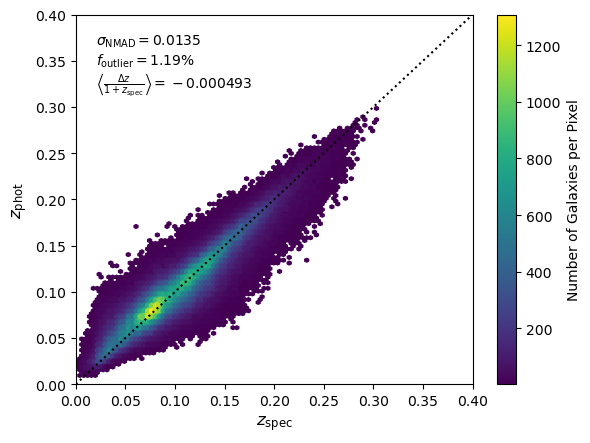

In [7]:
delta_z = train_table['z'] - train_table['zphot']
sigma_NMAD = 1.4826 * np.median(np.abs(delta_z / (1 + train_table['z']) - np.median(delta_z / (1 + train_table['z']))))

outliers = (np.abs(delta_z / (1 + train_table['z'])) > 0.05)
outlier_fraction = np.sum(outliers) / len(outliers)

mean_deviation = np.mean(delta_z / (1 + train_table['z']))

plt.hexbin(train_table['z'], train_table['zphot'], mincnt=3)
plt.axline((0.2, 0.2), slope=1, c='Black', ls='dotted')
plt.xlim(0, 0.4)
plt.ylim(0, 0.4)
plt.xlabel(r'$z_{\rm spec}$', fontsize=12)
plt.ylabel(r'$z_{\rm phot}$', fontsize=12)
plt.colorbar(label='Number of Galaxies per Pixel')
plt.text(0.05, 0.8,
         f'$\\sigma_{{\\rm NMAD}}={sigma_NMAD:.4f}$\n' + 
         f'$f_{{\\rm outlier}}={100 * outlier_fraction:.2f}\%$\n' + 
         f'$\\left\\langle\\frac{{\Delta z}}{{1+z_{{\\rm spec}}}}\\right\\rangle={mean_deviation:.6f}$',
         transform=plt.gca().transAxes)
plt.show()

### Q7. Train the forest(s)

Using `n_estimators` (i.e. number of trees) in (5, 20, 50, 200, 500), train a random forest. You can use all the cores your CPU has with `n_jobs=-1`. Limit the maximum number of features at each branch with `sqrt`. Use the inverse variance of the redshifts as your sample weights. Plot the `oob_score` vs the number of trees. For each of the forests you trained, make a plot of the feature importances. (35 pts)

In [8]:
n_estimators = [5, 20, 50, 200, 500]
regressors = [sklearn.ensemble.RandomForestRegressor(n, random_state=0, max_features='sqrt', n_jobs=-1, oob_score=True) for n in n_estimators]
for regressor in regressors:
    regressor.fit(train_table[train_cols], train_table[pred_cols], train_table['zErr']**(-2))

/Users/mustafamemon/miniconda3/envs/astr596/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/mustafamemon/miniconda3/envs/astr596/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[-0.00656717  0.72154362  0.75104336  0.76309393  0.76558474]


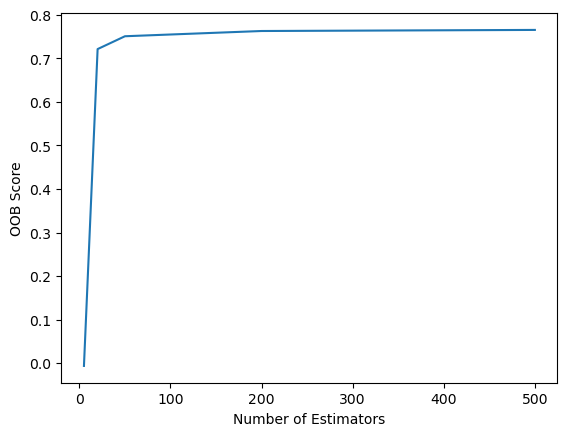

In [9]:
# Get OOB score for each forest
oob_scores = np.array([regressor.oob_score_ for regressor in regressors])
print(oob_scores)
plt.plot(n_estimators, oob_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('OOB Score')
plt.show()

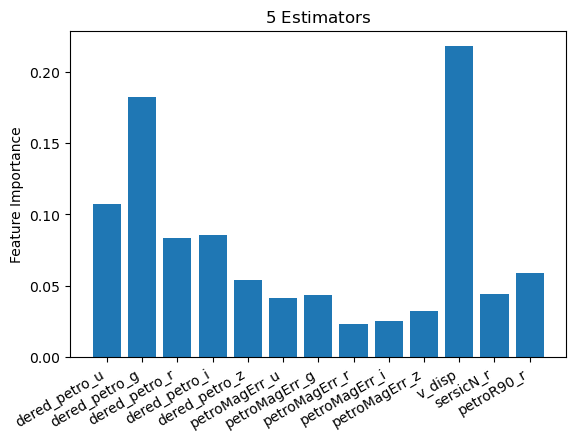

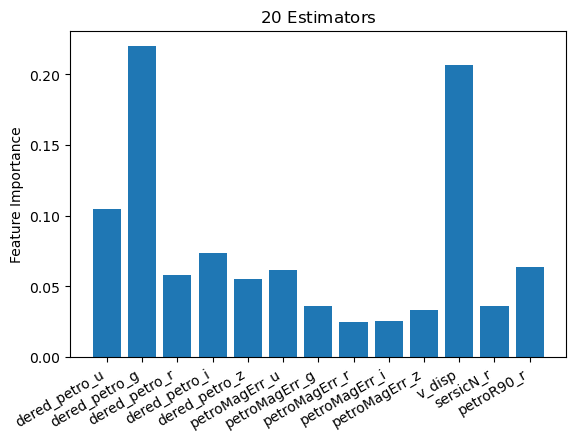

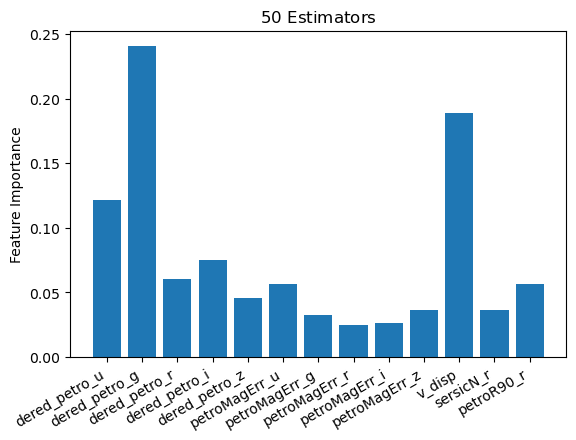

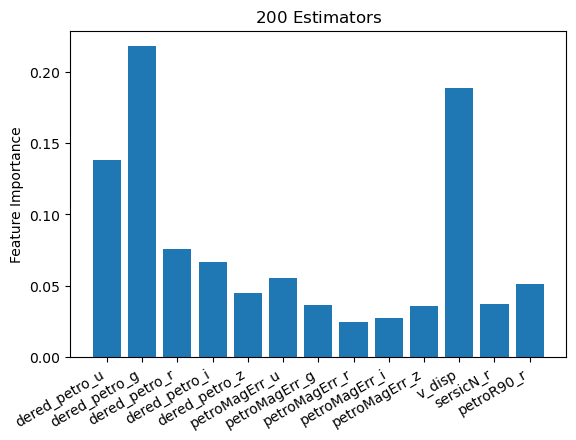

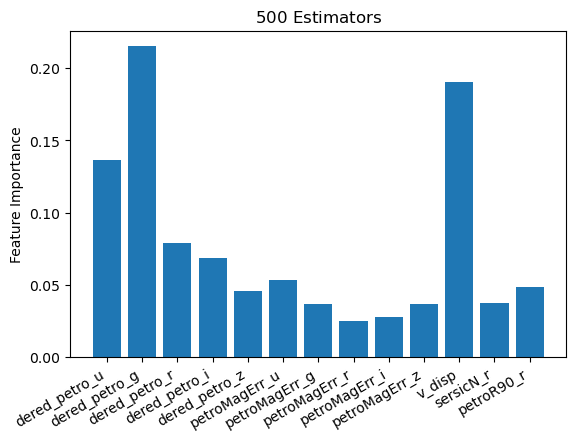

In [10]:
# Plot the feature importances for each forest
n_features = len(train_cols)
for (regressor, n) in zip(regressors, n_estimators):
    fig, ax = plt.subplots()
    ax.bar(range(n_features), regressor.feature_importances_)
    ax.set_xticks(range(n_features))
    ax.set_xticklabels(train_cols)
    ax.set_title(f'${n}$ Estimators')
    ax.set_ylabel('Feature Importance')
    fig.autofmt_xdate()
    plt.show()

### Q8. Test.

Pick your best performing forest from Q7. Load the test data (remember to apply any cuts you did to the training data). Use your random forest to predict the photo-z. Replicate Fig. 3 and Fig. 4 with your photo-z prediction *and* the photo-z prediction from SDSS included in the file. (30 pts, 10 pts for prediction, 10 for the two figures)

In [11]:
print(n_estimators[oob_scores.argmax()])

500


I find that the forest with 500 trees had the highest OOB score, so I use it going forward.

In [12]:
best_regressor = regressors[oob_scores.argmax()]
prediction = best_regressor.predict(test_table[train_cols])

Next, I plot the $z_{\rm phot}$ predicted by this forest against the given $z_{\rm spec}$.

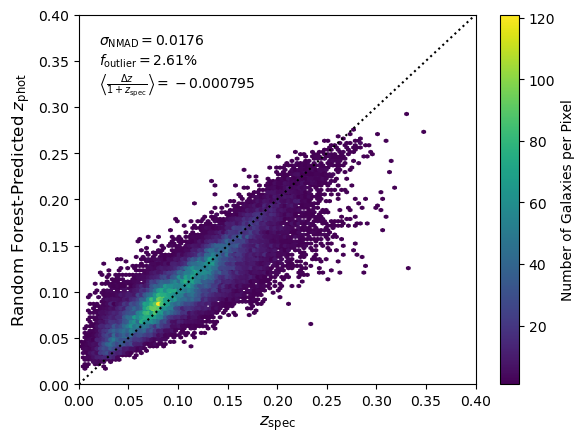

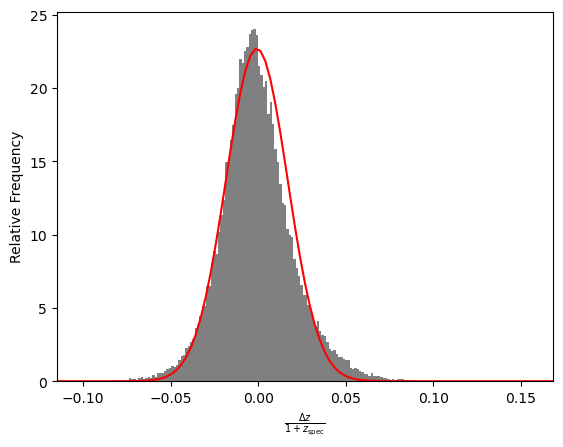

In [15]:
delta_z = test_table['z'] - prediction[:, 2]
sigma_NMAD = 1.4826 * np.median(np.abs(delta_z / (1 + test_table['z']) - np.median(delta_z / (1 + test_table['z']))))

outliers = (np.abs(delta_z / (1 + test_table['z'])) > 0.05)
outlier_fraction = np.sum(outliers) / len(outliers)

mean_deviation = np.mean(delta_z / (1 + test_table['z']))

plt.hexbin(test_table['z'], prediction[:, 2], mincnt=1)
plt.axline((0.2, 0.2), slope=1, c='Black', ls='dotted')
plt.xlim(0, 0.4)
plt.ylim(0, 0.4)
plt.xlabel(r'$z_{\rm spec}$', fontsize=12)
plt.ylabel(r'Random Forest-Predicted $z_{\rm phot}$', fontsize=12)
plt.colorbar(label='Number of Galaxies per Pixel')
plt.text(0.05, 0.8,
         f'$\\sigma_{{\\rm NMAD}}={sigma_NMAD:.4f}$\n' + 
         f'$f_{{\\rm outlier}}={100 * outlier_fraction:.2f}\%$\n' + 
         f'$\\left\\langle\\frac{{\Delta z}}{{1+z_{{\\rm spec}}}}\\right\\rangle={mean_deviation:.6f}$',
         transform=plt.gca().transAxes)
plt.show()

plt.hist(delta_z / (1 + test_table['z']), color='Gray', bins='fd', histtype='stepfilled', density=True)
xlim = plt.xlim()
x_arr = np.linspace(xlim[0], xlim[1], 101)
plt.plot(x_arr, 1 / np.sqrt(2 * np.pi * sigma_NMAD**2) * np.exp(-(x_arr - mean_deviation)**2 / (2 * sigma_NMAD**2)),
         c='Red')
plt.xlim(xlim)
plt.xlabel(r'$\frac{\Delta z}{1+z_{\rm spec}}$')
plt.ylabel('Relative Frequency')
plt.show()

The distribution of redshift prediction errors has a notable difference from a Gaussian with mean $\sigma_{\rm NMAD}$ and standard deviation $\left\langle\frac{\Delta z}{1+z_{\rm spec}}\right\rangle$. The distribution peaks slightly below 0 and is also slightly asymmetric.

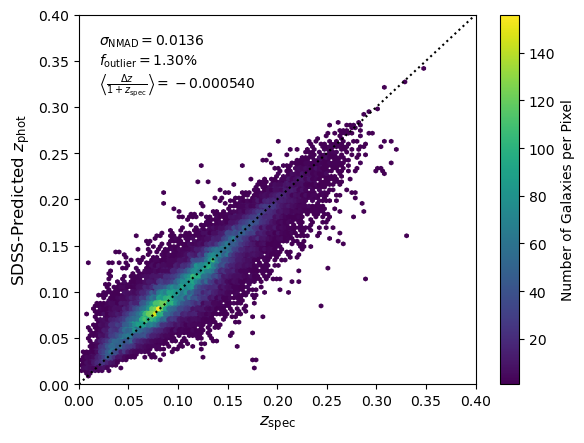

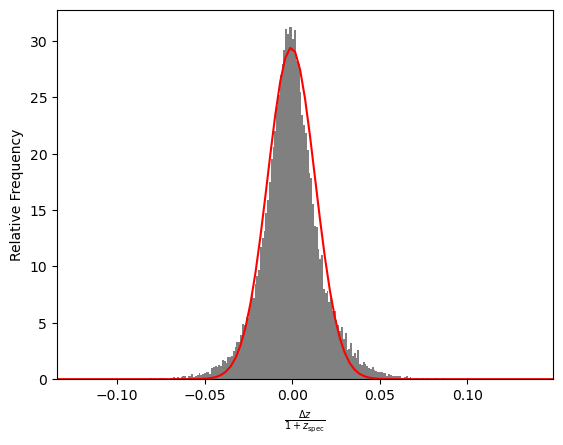

In [17]:
delta_z = test_table['z'] - test_table['zphot']
sigma_NMAD = 1.4826 * np.median(np.abs(delta_z / (1 + test_table['z']) - np.median(delta_z / (1 + test_table['z']))))

outliers = (np.abs(delta_z / (1 + test_table['z'])) > 0.05)
outlier_fraction = np.sum(outliers) / len(outliers)

mean_deviation = np.mean(delta_z / (1 + test_table['z']))

plt.hexbin(test_table['z'], test_table['zphot'], mincnt=1)
plt.axline((0.2, 0.2), slope=1, c='Black', ls='dotted')
plt.xlim(0, 0.4)
plt.ylim(0, 0.4)
plt.xlabel(r'$z_{\rm spec}$', fontsize=12)
plt.ylabel(r'SDSS-Predicted $z_{\rm phot}$', fontsize=12)
plt.colorbar(label='Number of Galaxies per Pixel')
plt.text(0.05, 0.8,
         f'$\\sigma_{{\\rm NMAD}}={sigma_NMAD:.4f}$\n' + 
         f'$f_{{\\rm outlier}}={100 * outlier_fraction:.2f}\%$\n' + 
         f'$\\left\\langle\\frac{{\Delta z}}{{1+z_{{\\rm spec}}}}\\right\\rangle={mean_deviation:.6f}$',
         transform=plt.gca().transAxes)
plt.show()

plt.hist(delta_z / (1 + test_table['z']), color='Gray', bins='fd', histtype='stepfilled', density=True)
xlim = plt.xlim()
x_arr = np.linspace(xlim[0], xlim[1], 101)
plt.plot(x_arr, 1 / np.sqrt(2 * np.pi * sigma_NMAD**2) * np.exp(-(x_arr - mean_deviation)**2 / (2 * sigma_NMAD**2)),
         c='Red')
plt.xlim(xlim)
plt.xlabel(r'$\frac{\Delta z}{1+z_{\rm spec}}$')
plt.ylabel('Relative Frequency')
plt.show()

The distribution of redshift prediction errors for the SDSS-predicted photometric redshifts also appears to be slightly non-Gaussian, with a narrower peak and stronger wings. Unlike the distribution of errors for the random forest, this ditribution appears to be symmetric.